<a href="https://colab.research.google.com/github/Johnson-Jeeva/HeatInjuryResearch/blob/main/HeatInjuryResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas matplotlib seaborn scipy

In [29]:
import pandas as pd
import numpy as np

# 1. Load datasets
climate = pd.read_csv('pima_heatwave_monthly.csv')
hospital = pd.read_csv('Annual_Hospitalization.csv')
emergency = pd.read_csv('Annual_Emergencies.csv')
death = pd.read_csv('State_Death_AZ_X30.csv')

# 2. Clean the combined "Age Group\"Sex" column in hospital and emergency data
def clean_age_sex(df):
    col = [c for c in df.columns if 'Age' in c and 'Sex' in c][0]
    df[col] = df[col].astype(str).str.replace('"', '', regex=False)
    df['Age_Group'] = df[col].str.extract(r'(>=?\s*\d+\+?)')
    df['Sex'] = df[col].str.extract(r'(Male|Female)')
    return df

hospital = clean_age_sex(hospital)
emergency = clean_age_sex(emergency)

# Convert Value columns to numeric
hospital['Value'] = pd.to_numeric(hospital['Value'], errors='coerce').fillna(0)
emergency['Value'] = pd.to_numeric(emergency['Value'], errors='coerce').fillna(0)

# 3. Filter for Arizona and 65+ Age Group
hospital = hospital[(hospital['State'] == 'Arizona') &
                    (hospital['Age_Group'].str.contains('65', na=False))]
emergency = emergency[(emergency['State'] == 'Arizona') &
                      (emergency['Age_Group'].str.contains('65', na=False))]

# 4. Clean and filter mortality data
death = death[death['State'].str.contains('Arizona', na=False)]
death = death[['State','Year','Deaths','Population']]
death = death.dropna(subset=['Year', 'Deaths'])
death['Year'] = death['Year'].astype(int)
death = death.groupby('Year', as_index=False)['Deaths'].sum()

# 5. Aggregate hospital and emergency data to yearly totals
hospital_yr = hospital.groupby('Year')['Value'].sum().reset_index(name='Hospitalizations')
emergency_yr = emergency.groupby('Year')['Value'].sum().reset_index(name='ED_Visits')

In [30]:
climate_yr = (
    climate.groupby('year')
    .agg({
        'avg_TMAX': 'mean',
        'avg_TMIN': 'mean',
        'heatwave_days': 'sum',
        'precip_total': 'sum'
    })
    .reset_index()
    .rename(columns={'year':'Year'})
)

In [31]:
merged = (
    climate_yr
    .merge(hospital_yr, on='Year', how='left')
    .merge(emergency_yr, on='Year', how='left')
    .merge(death[['Year','Deaths']], on='Year', how='left')
)

merged.head()

,Year,avg_TMAX,avg_TMIN,heatwave_days,precip_total,Hospitalizations,ED_Visits,Deaths
0,2010,73.555527,48.275227,122,9.550,124,153.0,49.0
1,2011,84.129691,57.273895,241,19.685,158,201.0,58.0
2,2012,85.971830,58.679179,247,13.140,130,230.0,51.0
3,2013,84.349214,58.183531,230,15.780,133,217.0,56.0
4,2014,85.291850,59.514620,215,18.185,122,219.0,37.0


In [32]:
merged

,Year,avg_TMAX,avg_TMIN,heatwave_days,precip_total,Hospitalizations,ED_Visits,Deaths
0,2010,73.555527,48.275227,122,9.550,124,153.0,49.0
1,2011,84.129691,57.273895,241,19.685,158,201.0,58.0
2,2012,85.971830,58.679179,247,13.140,130,230.0,51.0
3,2013,84.349214,58.183531,230,15.780,133,217.0,56.0
4,2014,85.291850,59.514620,215,18.185,122,219.0,37.0
5,2015,84.725221,59.929475,222,19.150,136,269.0,48.0
6,2016,86.327174,60.201436,205,18.090,165,344.0,104.0
7,2017,85.776641,59.632803,205,13.930,192,391.0,110.0
8,2018,85.052465,60.159511,238,23.035,212,363.0,93.0
9,2019,74.234091,50.060675,188,23.400,210,372.0,119.0


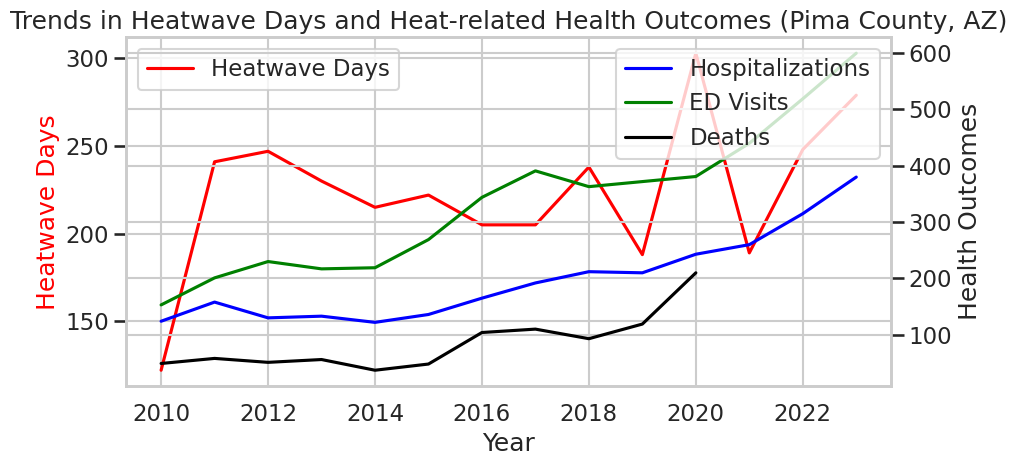

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=merged, x='Year', y='heatwave_days', color='red', label='Heatwave Days', ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(data=merged, x='Year', y='Hospitalizations', color='blue', label='Hospitalizations', ax=ax2)
sns.lineplot(data=merged, x='Year', y='ED_Visits', color='green', label='ED Visits', ax=ax2)
sns.lineplot(data=merged, x='Year', y='Deaths', color='black', label='Deaths', ax=ax2)

ax1.set_ylabel('Heatwave Days', color='red')
ax2.set_ylabel('Health Outcomes')
plt.title('Trends in Heatwave Days and Heat-related Health Outcomes (Pima County, AZ)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

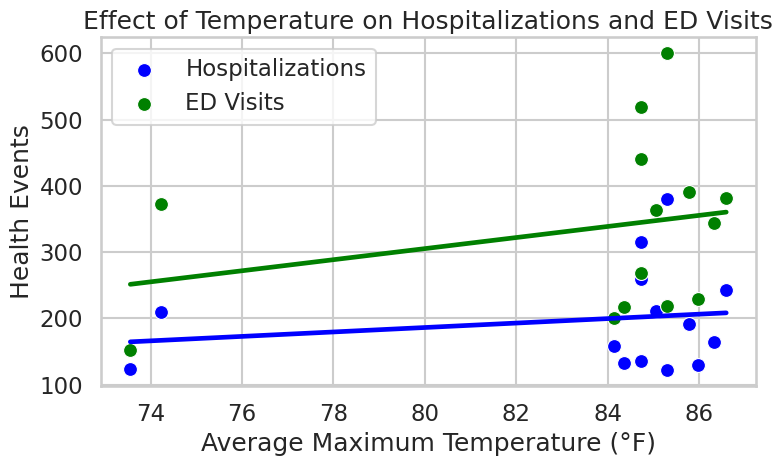

In [34]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged, x='avg_TMAX', y='Hospitalizations', color='blue', s=100, label='Hospitalizations')
sns.scatterplot(data=merged, x='avg_TMAX', y='ED_Visits', color='green', s=100, label='ED Visits')
sns.regplot(data=merged, x='avg_TMAX', y='Hospitalizations', scatter=False, color='blue', ci=None)
sns.regplot(data=merged, x='avg_TMAX', y='ED_Visits', scatter=False, color='green', ci=None)

plt.xlabel('Average Maximum Temperature (°F)')
plt.ylabel('Health Events')
plt.title('Effect of Temperature on Hospitalizations and ED Visits')
plt.legend()
plt.tight_layout()
plt.show()

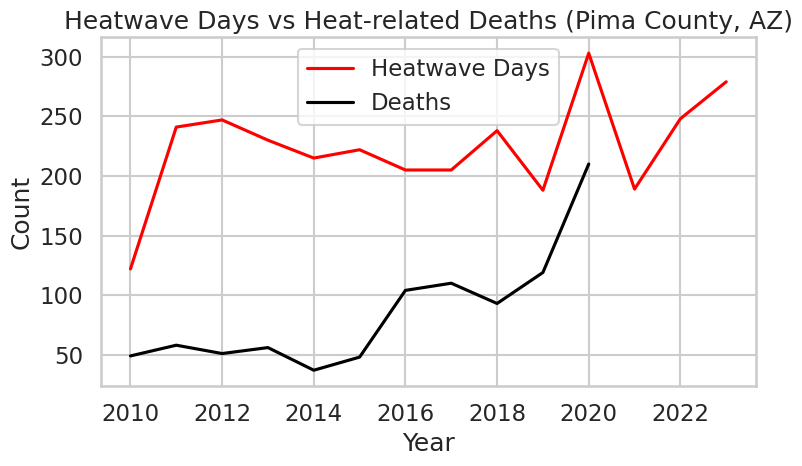

In [35]:
plt.figure(figsize=(8,5))
sns.lineplot(data=merged, x='Year', y='heatwave_days', color='red', label='Heatwave Days')
sns.lineplot(data=merged, x='Year', y='Deaths', color='black', label='Deaths')

plt.ylabel('Count')
plt.title('Heatwave Days vs Heat-related Deaths (Pima County, AZ)')
plt.legend()
plt.tight_layout()
plt.show()

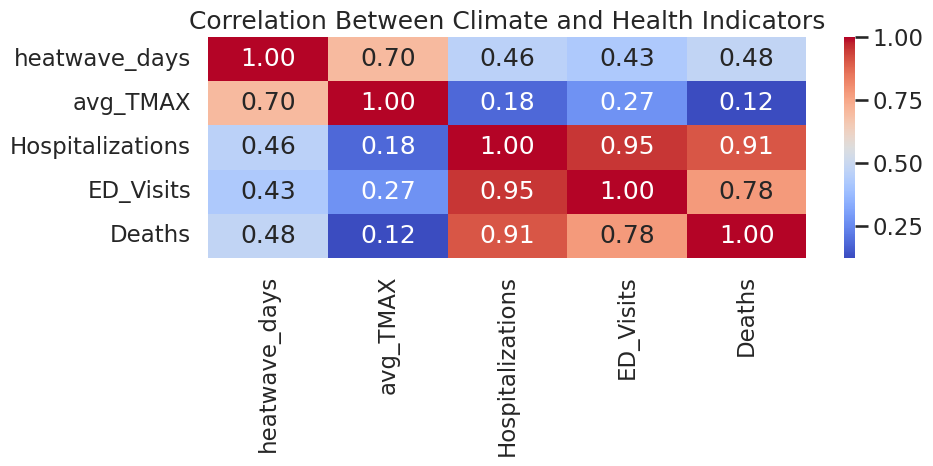

In [42]:
plt.figure(figsize=(10,5))
corr = merged[['heatwave_days','avg_TMAX','Hospitalizations','ED_Visits','Deaths']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Climate and Health Indicators')
plt.tight_layout()
plt.show()

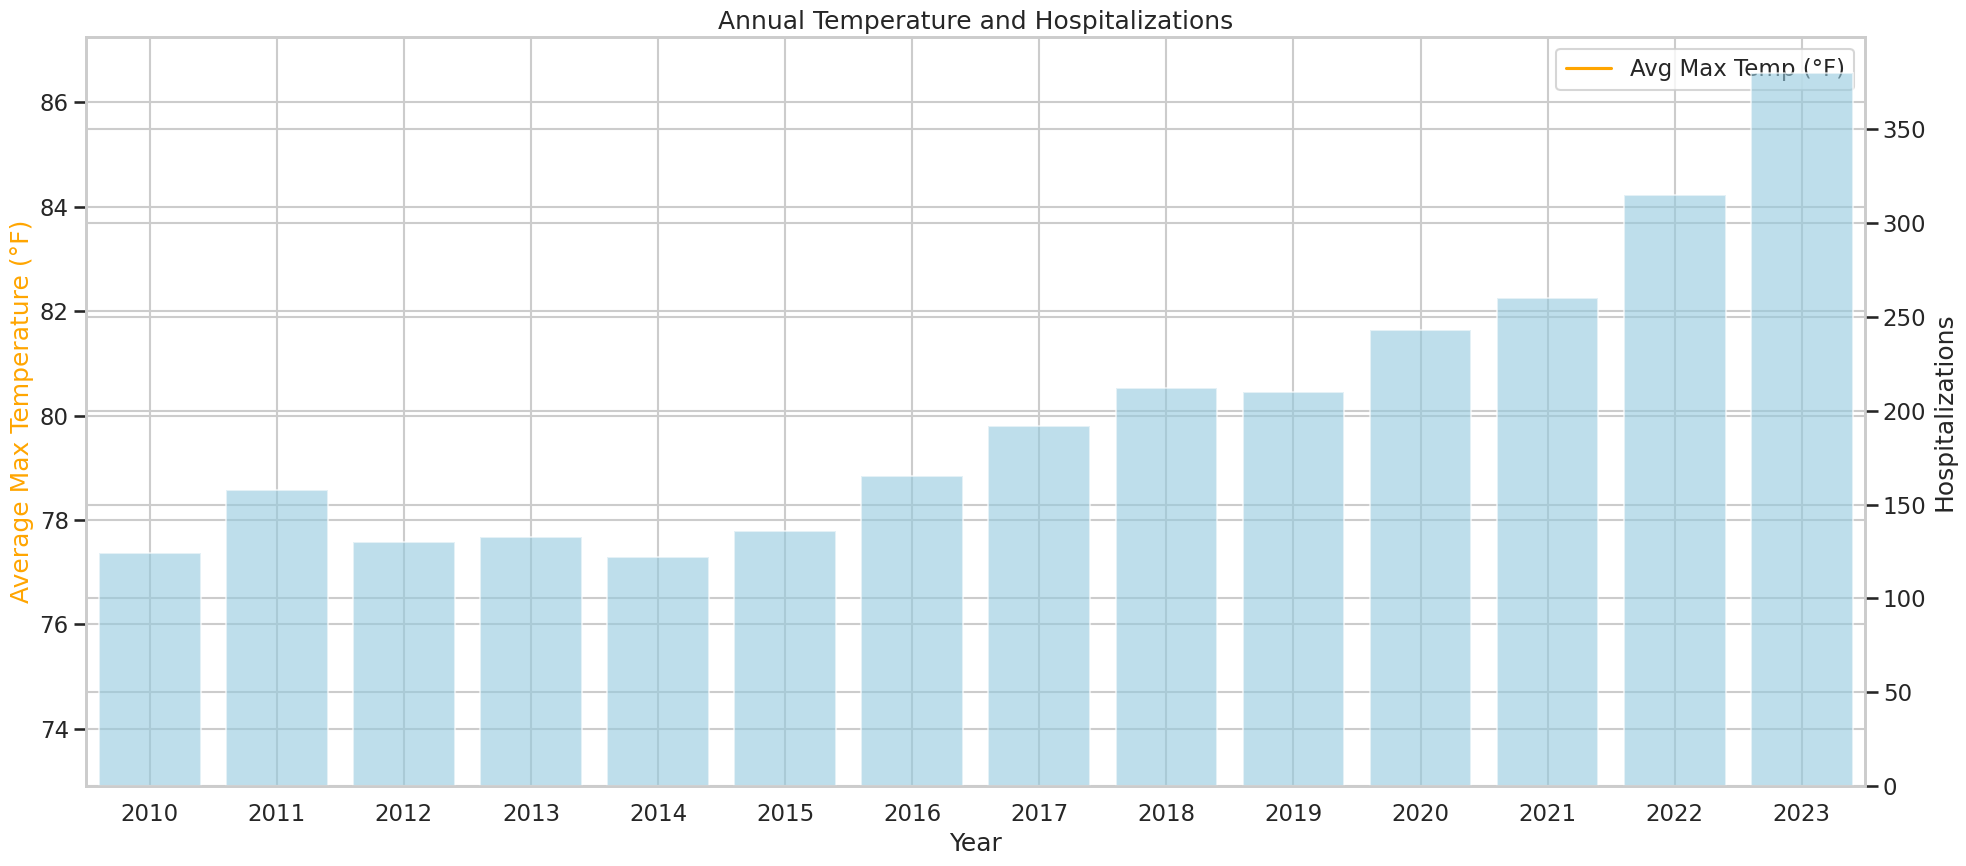

In [41]:
fig, ax1 = plt.subplots(figsize=(20,9))
sns.lineplot(data=merged, x='Year', y='avg_TMAX', color='orange', label='Avg Max Temp (°F)', ax=ax1)

ax2 = ax1.twinx()
sns.barplot(data=merged, x='Year', y='Hospitalizations', color='skyblue', alpha=0.6, ax=ax2)

ax1.set_ylabel('Average Max Temperature (°F)', color='orange')
ax2.set_ylabel('Hospitalizations')
plt.title('Annual Temperature and Hospitalizations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()